In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/frenchenglish-translation/fra.tsv


#### Importing data

In [2]:
data = pd.read_csv('/kaggle/input/frenchenglish-translation/fra.tsv', delimiter='\t')
data.head()

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


#### Since the dataset has around 1,50,000 training examples but we will be using only 60,000 rows to keep it simple.

In [3]:
data = data.iloc[:55000, :]

english = data.english.values
french = data.french.values

#### Exploring dataset

In [4]:
print("Length of english sentence:", len(english))
print("Length of french sentence:", len(french))
print('-'*20)
print(english[100])
print('-'*20)
print(french[100])

Length of english sentence: 55000
Length of french sentence: 55000
--------------------
Come in.
--------------------
Entre !


#### Remove all punctuations from text

In [5]:
english = [s.translate(str.maketrans('', '', string.punctuation)) for s in english]
french = [s.translate(str.maketrans('', '', string.punctuation)) for s in french]

print(english[100])
print('-'*20)
print(french[100])

Come in
--------------------
Entre 


#### Convert all examples to lowercase

In [6]:
english = [s.lower() if isinstance(s, str) else s for s in english]
french = [s.lower() if isinstance(s, str) else s for s in french]

print(english[100])
print('-'*20)
print(french[100])

come in
--------------------
entre 


#### Visualise the length of examples

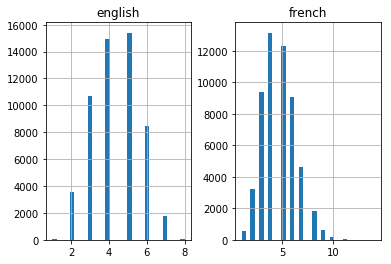

In [7]:
eng_l = [len(s.split()) for s in english]
fre_l = [len(s.split()) for s in french]

length_df = pd.DataFrame({'english': eng_l, 'french': fre_l})
length_df.hist(bins=30)
plt.show()

In [8]:
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Embedding, LSTM, RepeatVector, Dropout, Bidirectional, Flatten

Using TensorFlow backend.


In [9]:
def tokenizer(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

english_tokenizer = tokenizer(english)
french_tokenizer = tokenizer(french)

word_index_english = english_tokenizer.word_index
word_index_french = french_tokenizer.word_index

eng_vocab_size = len(word_index_english) + 1
fre_vocab_size = len(word_index_french) + 1

In [10]:
print("Size of english vocab:", len(word_index_english))
print("Size of french vocab:", len(word_index_french))

Size of english vocab: 6908
Size of french vocab: 15743


In [11]:
max_len_eng = max(eng_l)
max_len_fre = max(fre_l)

print("Max length of english sentence:", max_len_eng)
print("Max length of french sentence:", max_len_fre)

Max length of english sentence: 8
Max length of french sentence: 14


In [12]:
english = pd.Series(english).to_frame('english')
french = pd.Series(french).to_frame('french')

dummy_df = pd.concat([english, french], axis=1)
train, test = train_test_split(dummy_df, test_size=0.1, random_state=42)

train_english = train.english.values
train_french = train.french.values

test_english = test.english.values
test_french = test.french.values

In [13]:
def encode_sequences(tokenizer, length, text):
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=length, padding='post')
    return sequences

In [14]:
eng_seq = encode_sequences(english_tokenizer, max_len_eng, train_english)
fre_seq = encode_sequences(french_tokenizer, max_len_fre, train_french)

# test_english = encode_sequences(english_tokenizer, max_len_eng, test_english)
test_french = encode_sequences(french_tokenizer, max_len_fre, test_french)

print(eng_seq[10])
print(fre_seq[10])

[857  55   0   0   0   0   0   0]
[599   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [15]:
def nmt_model(in_vocab_size, out_vocab_size, in_timestep, out_timestep, units):
    model = Sequential()
    model.add(Embedding(in_vocab_size, units, input_length=in_timestep, mask_zero=True))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4)))
    model.add(Dropout(0.5))
    model.add(RepeatVector(out_timestep))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Dense(out_vocab_size, activation="softmax"))
    return model

In [16]:
model = nmt_model(fre_vocab_size, eng_vocab_size, max_len_fre, max_len_eng, 256)

In [17]:
rms = optimizers.RMSprop(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=rms, metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 256)           4030464   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 8, 512)            1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 6909)          

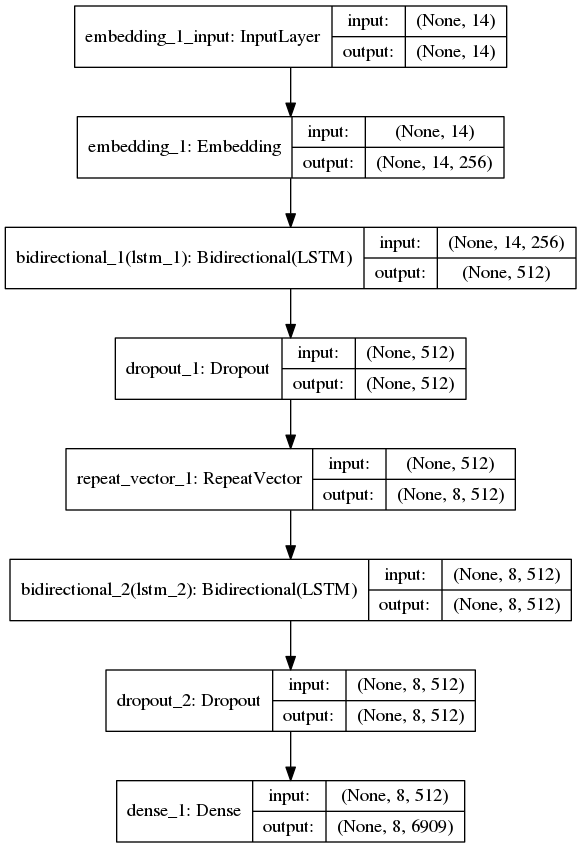

In [19]:
plot_model(model, show_shapes=True)

In [20]:
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [21]:
eng_seq = eng_seq.reshape(eng_seq.shape[0], eng_seq.shape[1], 1)
history = model.fit(fre_seq, eng_seq, batch_size=1024, epochs=300, verbose=1, validation_split=0.05, shuffle=True, callbacks=[checkpoint])

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 47025 samples, validate on 2475 samples
Epoch 1/300
47025/47025 [==============================] - 11s 235us/step - loss: 4.4908 - accuracy: 0.4251 - val_loss: 3.4220 - val_accuracy: 0.4899

Epoch 00001: val_accuracy improved from -inf to 0.48990, saving model to weights-improvement.hdf5
Epoch 2/300
47025/47025 [==============================] - 7s 153us/step - loss: 3.1821 - accuracy: 0.5211 - val_loss: 2.8403 - val_accuracy: 0.5533

Epoch 00002: val_accuracy improved from 0.48990 to 0.55328, saving model to weights-improvement.hdf5
Epoch 3/300
47025/47025 [==============================] - 7s 151us/step - loss: 2.7597 - accuracy: 0.5653 - val_loss: 2.5117 - val_accuracy: 0.5947

Epoch 00003: val_accuracy improved from 0.55328 to 0.59475, saving model to weights-improvement.hdf5
Epoch 4/300
47025/47025 [==============================] - 7s 151us/step - loss: 2.4879 - accuracy: 0.5914 - val_loss: 2.3356 - val_accuracy: 0.6160

Epoch 00004: val_accuracy improved from 0.59475 to

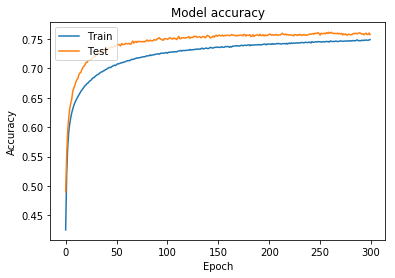

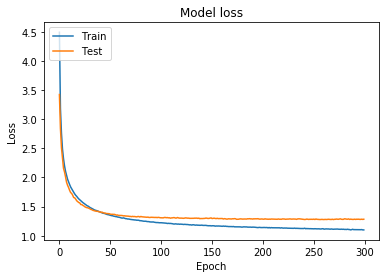

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
prediction = model.predict_classes(test_french.reshape(test_french.shape[0], test_french.shape[1]))

In [24]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [25]:
preds_text = []
for i in tqdm(prediction):
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], english_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], english_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(' '.join(temp))

100%|██████████| 5500/5500 [01:42<00:00, 53.66it/s]


In [26]:
pred_df = pd.DataFrame({'actual' : test_english, 'predicted' : preds_text})

In [27]:
pred_df.head(7)

,actual,predicted
0,this is simply amazing,its just acceptable
1,did you know him well,the good
2,i feel tired and exhausted,i feel tired of tired
3,im very strict,im very strict
4,who allowed him in,who let him in
5,im not hitting on you,im not on you
6,my mother is in the kitchen,my mother is cooking


In [28]:
pred_df.tail(7)

,actual,predicted
5493,youre very astute,youre very astute
5494,dont buy that,dont bother it
5495,youre a funny gal,youre a girl
5496,stay with us,the house is in with
5497,do you play any instruments,do you play any sports
5498,i shouldve gone home,i shouldve have home
5499,youre very open,youre very open
